In [30]:
import rpy2.robjects as robjects
import numpy as np
import os as os
from rpy2.robjects import numpy2ri
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from scipy.spatial.distance import pdist, squareform
from scipy.special import expit
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from gp_diffscales import AladynSurvivalModeldiffKernels, compute_smoothed_prevalence


%load_ext autoreload
%autoreload 2
# Specify the path to your data files
data_path = "/Users/sarahurbut/tensornoulli_ehr_new/data"

# Activate automatic conversion between R and NumPy arrays
numpy2ri.activate()# Load data saved as .rds files
Y = np.array(robjects.r['readRDS'](os.path.join(data_path, 'Y.rds')))
E = np.array(robjects.r['readRDS'](os.path.join(data_path, 'event_for_aladynoulli.rds')))
G = np.array(robjects.r['readRDS'](os.path.join(data_path, 'prs.rds')))

E = E.astype(int)

# G should be float64
G = G.astype(float)
G.shape
G = G.T
print("G shape after transposition:", G.shape)

# Convert to PyTorch tensors
Y_tensor = torch.FloatTensor(Y)
E_tensor = torch.FloatTensor(E)
G_tensor = torch.FloatTensor(G)

# Get dimensions
N, D, T = Y_tensor.shape
P = G_tensor.shape[1]
T = int(E_tensor.max() + 1)  # 0-indexed time
K = 10  # number of topics

# Print shapes to verify
print("Tensor shapes:")
print(f"Y: {Y_tensor.shape}")  # [N, D]
print(f"E: {E_tensor.shape}")  # [N, D]
print(f"G: {G_tensor.shape}")  # [N, P]
print(f"Time range: 0 to {T-1}")
print(T)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
G shape after transposition: (9661, 36)
Tensor shapes:
Y: torch.Size([9661, 348, 51])
E: torch.Size([9661, 348])
G: torch.Size([9661, 36])
Time range: 0 to 50
51


In [38]:
prevalence_t = compute_smoothed_prevalence(Y, window_size=5)

# Initialize model
model2 = AladynSurvivalModeldiffKernels(N, D, T, K, P, G, Y, prevalence_t)

# Train model
history = model2.fit(
    event_times=E,
    num_epochs=1000,
    learning_rate=5e-4,
    lambda_reg=1e-2,
    convergence_threshold=0.1,
    patience=20
)



Epoch 0
Loss: 3351809.2500
Lambda length scales: [14.227839  19.486547   6.6495934  6.13327    7.800187  19.919165
 24.915789  12.403636  21.248783   7.238061 ]
Phi length scales: [ 6.530303  9.137214 14.3797   21.338385 13.502306  8.146435 20.273333
 22.887882 22.081    22.900007]
Lambda amplitudes: [1.0005001 1.0005001 1.0005001 1.0005001 1.0005001 1.0005001 1.0005001
 1.0005001 1.0005001 1.0005001]
Phi amplitudes: [1.0005001 1.0005001 1.0005001 1.0005001 1.0005001 1.0005001 1.0005001
 1.0005001 1.0005001 1.0005001]
Max gradients - λ: 129.1955, φ: 100.4910, γ: 674.1735
Mean condition numbers - λ: 6958.06, φ: 6833.24
Loss change: inf

Epoch 100
Loss: 1612181.5000
Lambda length scales: [14.178757  19.436766   6.604162   6.085759   7.7515407 19.869358
 24.865973  12.354638  21.19893    7.189484 ]
Phi length scales: [ 6.484829   9.0884495 14.33059   21.288465  13.4531975  8.09785
 20.22357   22.8381    22.031218  22.85024  ]
Lambda amplitudes: [1.0523254 1.052595  1.051216  1.0518429 1.

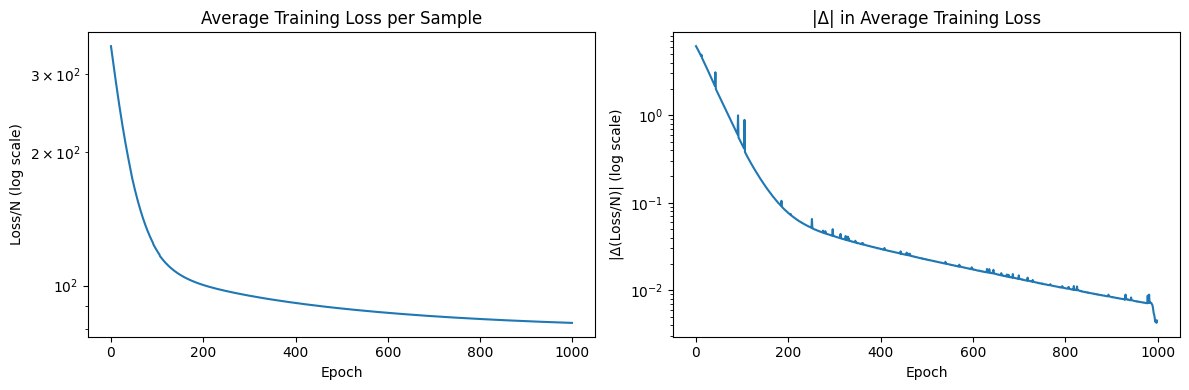

In [29]:

# Calculate per-sample loss
per_sample_loss = [l/N for l in history['loss']]

# Calculate change in loss between iterations
delta_loss = [per_sample_loss[i+1] - per_sample_loss[i] for i in range(len(per_sample_loss)-1)]

plt.figure(figsize=(12, 4))

# Per-sample loss
plt.subplot(1, 2, 1)
plt.plot(per_sample_loss)
plt.yscale('log')
plt.title('Average Training Loss per Sample')
plt.xlabel('Epoch')
plt.ylabel('Loss/N (log scale)')

# Change in per-sample loss
plt.subplot(1, 2, 2)
plt.plot([abs(d) for d in delta_loss])  # Using abs() for log scale
plt.yscale('log')
plt.title('|Δ| in Average Training Loss')
plt.xlabel('Epoch')
plt.ylabel('|Δ(Loss/N)| (log scale)')

plt.tight_layout()



In [35]:
# Initialize model
from gp_diffscales_withavgloss import *
model = AladynSurvivalModeldiffKernelsavgloss(N, D, T, K, P, G, Y, prevalence_t)

# Train model
history = model.fit(
    event_times=E,
    num_epochs=1000,
    learning_rate=1e-3,
    lambda_reg=1e-2,
    convergence_threshold=1e-2,
    patience=20
)


Epoch 0
Loss: 593.6250
Lambda length scales: [ 8.362684 17.517422  8.199981 24.60872  21.38269  21.871483 16.89964
 15.027885 16.234598 12.130131]
Phi length scales: [21.042557 15.675837 21.425943  8.61924  19.715519 20.82244  19.75071
 14.995614  9.124957 16.064093]
Lambda amplitudes: [1.0010005 1.0010005 1.0010005 1.0010005 1.0010005 1.0010005 1.0010005
 1.0010005 1.0010005 1.0010005]
Phi amplitudes: [1.0010005 1.0010005 1.0010005 1.0010005 1.0010005 1.0010005 1.0010005
 1.0010005 1.0010005 1.0010005]
Max gradients - λ: 0.0084, φ: 0.2103, γ: 0.0507
Mean condition numbers - λ: 6654.96, φ: 6896.74
Loss change: inf

Epoch 100
Loss: 151.1641
Lambda length scales: [ 8.267543 17.418127  8.104753 24.509071 21.282972 21.771835 16.800364
 14.934404 16.140036 12.033784]
Phi length scales: [20.94301  15.582508 21.325796  8.523491 19.615623 20.723043 19.650965
 14.90235   9.029482 15.970517]
Lambda amplitudes: [1.1088156 1.1100969 1.1088598 1.1101977 1.1102479 1.1101853 1.1101129
 1.1079184 1.1

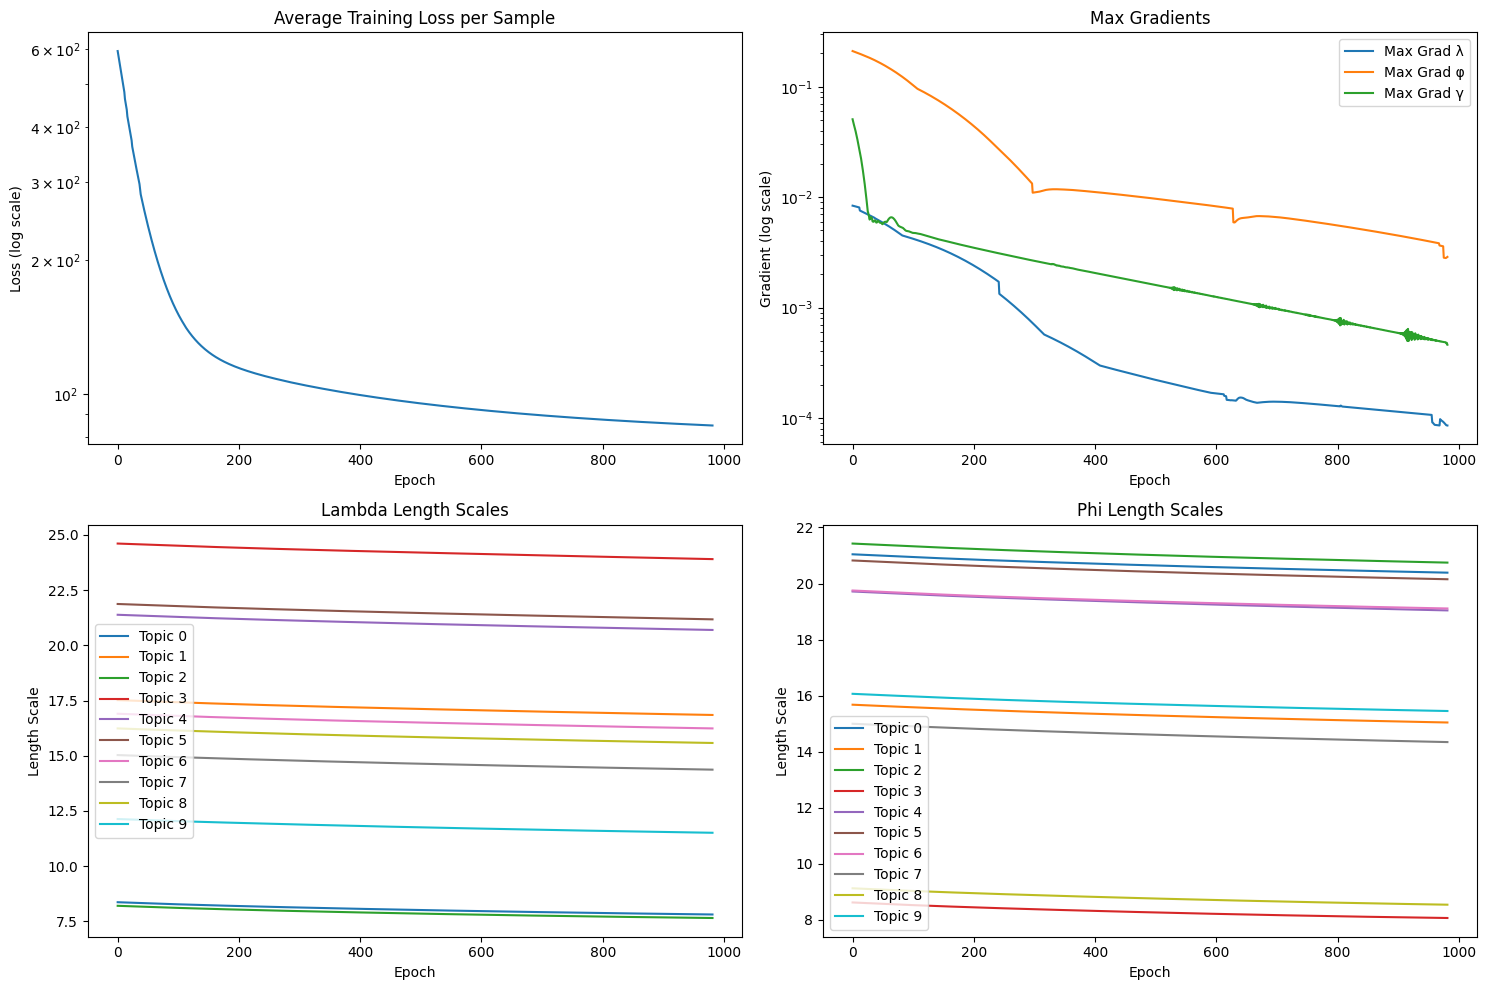

In [36]:
def plot_training_diagnostics(history):
    plt.figure(figsize=(15, 10))
    
    # Plot average training loss
    plt.subplot(2, 2, 1)
    plt.plot(history['loss'])
    plt.yscale('log')
    plt.title('Average Training Loss per Sample')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (log scale)')
    
    # Plot max gradients
    plt.subplot(2, 2, 2)
    plt.plot(history['max_grad_lambda'], label='Max Grad λ')
    plt.plot(history['max_grad_phi'], label='Max Grad φ')
    plt.plot(history['max_grad_gamma'], label='Max Grad γ')
    plt.yscale('log')
    plt.title('Max Gradients')
    plt.xlabel('Epoch')
    plt.ylabel('Gradient (log scale)')
    plt.legend()
    
    # Plot lambda length scales
    plt.subplot(2, 2, 3)
    for k in range(len(history['lambda_length_scales'][0])):
        plt.plot([scales[k] for scales in history['lambda_length_scales']], label=f'Topic {k}')
    plt.title('Lambda Length Scales')
    plt.xlabel('Epoch')
    plt.ylabel('Length Scale')
    plt.legend()
    
    # Plot phi length scales
    plt.subplot(2, 2, 4)
    for k in range(len(history['phi_length_scales'][0])):
        plt.plot([scales[k] for scales in history['phi_length_scales']], label=f'Topic {k}')
    plt.title('Phi Length Scales')
    plt.xlabel('Epoch')
    plt.ylabel('Length Scale')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Assuming you have a history dictionary from training
plot_training_diagnostics(history)

/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_67564/4267676013.py:67: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


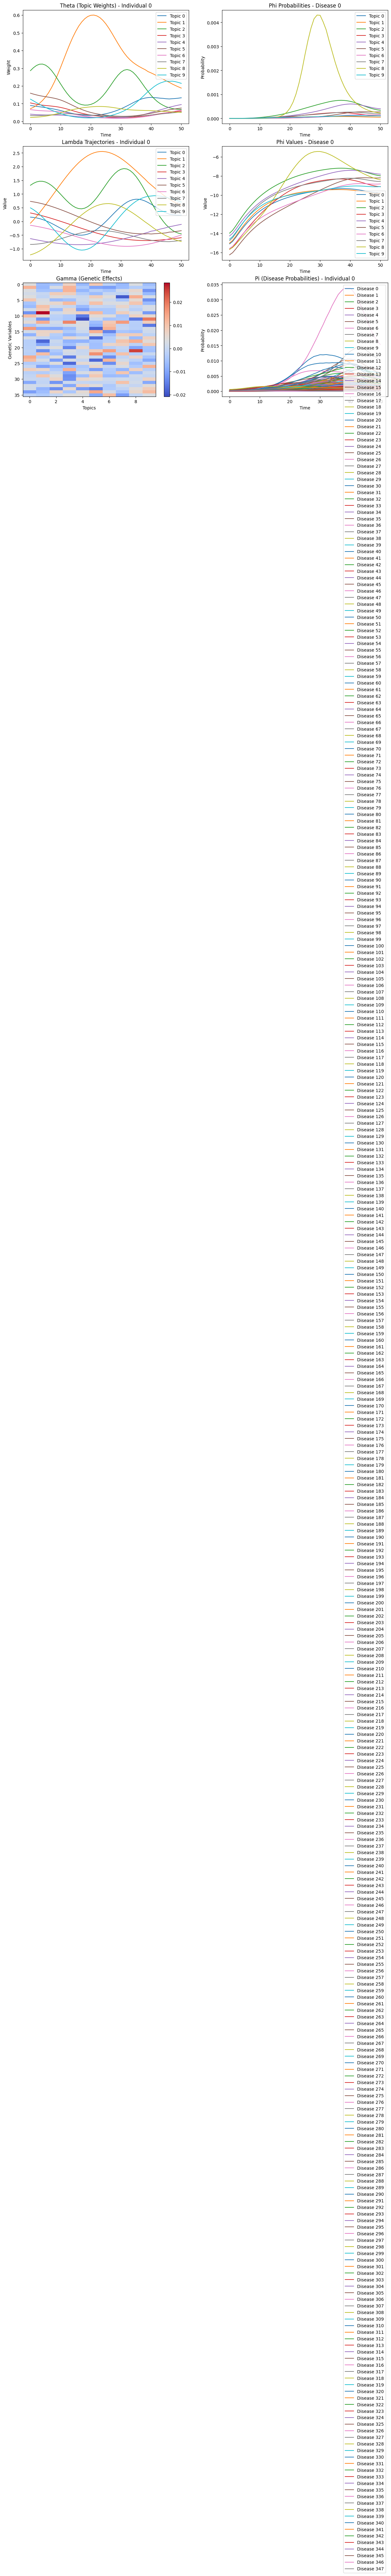

In [37]:
K=10
pi_pred, theta_pred, phi_pred = model.forward()

# Plot predicted theta only
pi_pred, theta, phi_prob = model.forward()

# Convert predictions to numpy
pi_pred_np = pi_pred.detach().numpy()

fig, axes = plt.subplots(3, 2, figsize=(15, 16))  # Made taller for extra row

# 1. Plot theta (topic weights) for first few individuals
theta_np = theta.detach().numpy()
for k in range(K):
    axes[0, 0].plot(theta_np[0, k, :], label=f'Topic {k}')
axes[0, 0].set_title('Theta (Topic Weights) - Individual 0')
axes[0, 0].set_xlabel('Time')
axes[0, 0].set_ylabel('Weight')
axes[0, 0].legend()

# 2. Plot phi probabilities for first few diseases
phi_prob_np = phi_prob.detach().numpy()
for k in range(K):
    axes[0, 1].plot(phi_prob_np[k, 0, :], label=f'Topic {k}')
axes[0, 1].set_title('Phi Probabilities - Disease 0')
axes[0, 1].set_xlabel('Time')
axes[0, 1].set_ylabel('Probability')
axes[0, 1].legend()

# 3. Plot lambda trajectories
lambda_np = model.lambda_.detach().numpy()
for k in range(K):
    axes[1, 0].plot(lambda_np[0, k, :], label=f'Topic {k}')
axes[1, 0].set_title('Lambda Trajectories - Individual 0')
axes[1, 0].set_xlabel('Time')
axes[1, 0].set_ylabel('Value')
axes[1, 0].legend()

# 4. Plot raw phi values
phi_np = model.phi.detach().numpy()
for k in range(K):
    axes[1, 1].plot(phi_np[k, 0, :], label=f'Topic {k}')
axes[1, 1].set_title('Phi Values - Disease 0')
axes[1, 1].set_xlabel('Time')
axes[1, 1].set_ylabel('Value')
axes[1, 1].legend()

# 5. Plot gamma (genetic effects) as heatmap
gamma_np = model.gamma.detach().numpy()
im = axes[2, 0].imshow(gamma_np, aspect='auto', cmap='coolwarm')
axes[2, 0].set_title('Gamma (Genetic Effects)')
axes[2, 0].set_xlabel('Topics')
axes[2, 0].set_ylabel('Genetic Variables')
plt.colorbar(im, ax=axes[2, 0])

# 6. Plot final survival probabilities for first individual
pi_np = pi_pred.detach().numpy()
for d in range(D):
    axes[2, 1].plot(pi_pred_np[0, d, :], label=f'Disease {d}')
axes[2, 1].set_title('Pi (Disease Probabilities) - Individual 0')
axes[2, 1].set_xlabel('Time')
axes[2, 1].set_ylabel('Probability')
axes[2, 1].legend()



plt.tight_layout()
plt.show()


